# Association Rules

## What are Association Rules?
Association rules are an example of *unsupervised (rule-based) learning*. The rule `A -> B` quantifies the likelihood of co-occurence i.e. if event A occurs, what is the likelihood that event B also occurs? The "events" A and B could represent anything e.g. certain items being present in a shopping basket, an employee being sick, a stock going up, and so on. We are interested in whether one event often occurs with another or increases the likelihood of another occuring (but we are **not** talking about causation!).

This form of analysis is used to discover relationships in large-scale transaction data recorded by point-of-sale (POS) systems in supermarkets. Data scientists were looking for items that were commonly bought together so that they could use this data to offer customers better deals. For example, the rule `{onions, potatoes} -> {burger}` found in the sales data of a supermarket would indicate that if a customer buys onions and potatoes together, they are likely to also buy burgers - a supermarket could use this data to intentionally stock certain items near to each other in the store, or supply particular discounts. 

Association Rules have since been used to find relationships between any sequences of things. Examples include things like web analytics (how someone behaves on a website), intrusion detection in cybersecurity (strange series of behaviours might indicate a hack) and bioinformatics in healthcare.

These rules are most commonly built using the Apriori and ECLAT algorithms. We're going to be using Apriori for this notebook exercise, which you have learnt about in the online reading!

## The Brief
Using supermarket data, find products that are commonly brought together (with a special interest in lime sales!) using the apriori algorithm.

## Load libraries 

If any of these are not installed already, you may need to install them using `pip install [package name]`. Unfortunately `sklearn` does not have an implementation of the apriori algorithm, and so we will use another library for this known as [`mlxtend`](http://rasbt.github.io/mlxtend/) (shorthand for "machine learning extensions").

In [2]:
import numpy as np # for extra mathematical functionality
import pandas as pd # for dataframe reading and manipulation 

from mlxtend.preprocessing import TransactionEncoder # for converting our data into a sparse matrix
from mlxtend.frequent_patterns import apriori # for finding frequent itemsets using the apriori algorithm
from mlxtend.frequent_patterns import association_rules # for deriving the association rules from frequent itemsets

## Source 

Download the instacart dataset and import it using `read.csv`. You'll actually need to read in 2 CSV files for this: `order_products__prior.csv` and `products.csv`. Make sure you only load in the first 20000 rows of `order_products__prior.csv` though as the full dataset is huge!

In [3]:
order_products_prior = pd.read_csv("instacart_2017_05_01/order_products__prior.csv", nrows = 20000)
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
products = pd.read_csv("instacart_2017_05_01/products.csv")
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Join the data

The data is supplied here in pretty much the exact form that instacart stored it in their database. We need to join the two files together in order to get it into a usable state! 

Currently the `order_products__prior.csv` doesn't have any product names, it only has IDs - we can map the product names to each product ID using the `products.csv` dataframe.

You'll learn more about how this is done in Sprint 4 when we look at SQL (it is called an ["inner join"](https://www.w3schools.com/sql/sql_join_inner.asp)). For now just use the following block of code, and have a read through. Try and summarise what it is doing and write it below, but no worries if not all of it makes sense for now!

In [6]:
order_baskets = pd.merge(order_products_prior, products, on = ['product_id'], how = 'inner')

# let's have a look at a sample of our merged dataframe
order_baskets.sample(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
2942,1641,25890,5,0,Boneless Skinless Chicken Breasts,49,12
10385,232,10132,7,0,Organic American Cheese Singles,21,16
6582,994,35221,1,1,Lime Sparkling Water,115,7
104,1679,17794,5,0,Carrots,83,4
17653,1196,28634,19,1,Hard Salami,96,20
18820,1562,29763,25,1,"Yogurt, Organic, Lowfat, Raspberry, 1-1/2% Mil...",120,16
16218,857,14429,18,1,Organic Ground Black Pepper,104,13
3079,1559,28849,3,0,No Salt Added Black Beans,59,15
13045,434,20957,15,0,Whole Grain Rice Cereal,92,18
9276,1330,20899,1,1,Goo Berry Pie Probugs Kefir,120,16


With the data merged, we can for example count the occurrences of each product name to see what the most purchased items are. 

In [7]:
order_baskets['product_name'].value_counts().head(20)

Banana                    321
Bag of Organic Bananas    236
Organic Strawberries      163
Organic Baby Spinach      137
Organic Hass Avocado      129
Organic Avocado           108
Strawberries               95
Large Lemon                91
Organic Raspberries        87
Limes                      77
Organic Yellow Onion       72
Organic Whole Milk         70
Organic Garlic             69
Organic Fuji Apple         65
Honeycrisp Apple           62
Organic Blueberries        59
Organic Lemon              55
Cucumber Kirby             54
Organic Half & Half        53
Original Hummus            53
Name: product_name, dtype: int64

Lots of fruit and veg - what a healthy group of customers!

### Grouping orders

At the moment, each item in a transaction is in a a separate row in the dataframe. We will need to group the different products bought in a given transaction as an array, into one row per transaction. Once we have done that, we can take a look at the first few entries to see how it's changed.

In [8]:
order_baskets.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [9]:
order_baskets = order_baskets.groupby(['order_id']) # group the dataset by order_id
order_baskets = order_baskets['product_name'] # select product_name only 
order_baskets = order_baskets.apply(np.array).reset_index()  # convert to np.array and reset index
order_baskets = order_baskets.rename(columns = {'product_name': 'Basket'}) # rename the column "Basket"

order_baskets.head()

,order_id,Basket
0,2,"[Organic Egg Whites, Michigan Organic Kale, Ga..."
1,3,[Total 2% with Strawberry Lowfat Greek Straine...
2,4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr..."
3,5,"[Bag of Organic Bananas, Just Crisp, Parmesan,..."
4,6,"[Cleanse, Dryer Sheets Geranium Scent, Clean D..."


## Explore & Transform

To work efficiently, the apriori algorithm requires a [**sparse matrix**](https://machinelearningmastery.com/sparse-matrices-for-machine-learning/). A sparse matrix is a matrix that has mostly 0 (or False) entries. They are cleverly stored in such a way that any cell with a 0 value in it can be ignored by the computer.

Creating a sparse matrix cuts out a lot of time and computational effort because a computer doesn't have to look at a great many cells within a dataframe - as far as the computer is concerned, cells with 0 values don't exist!

We can convert our dataframe into sparse matrix format using the `TransactionEncoder` function from `mlxtend`.

In [10]:
#transactions = order_baskets.iloc[:,1:].values
te = TransactionEncoder() # set up the TransactionEncoder object
te_ary = te.fit(order_baskets['Basket']).transform(order_baskets['Basket']) # fit it to our dataset

te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

This is a numpy array - let's convert it to a pandas dataframe, supplying the column names from the `.columns_` attribute of the `TransactionEncoder` object.

In [12]:
dataset = pd.DataFrame(te_ary, columns = te.columns_)

dataset.head()

,& Go! Hazelnut Spread + Pretzel Sticks,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,0% Milkfat Greek Plain Yogurt,0% Milkfat Greek Yogurt Honey,1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,...,Zucchini Noodles,from Concentrate Mango Nectar,gel hand wash sea minerals,in Gravy with Carrots Peas & Corn Mashed Potatoes & Meatloaf Nuggets,of Norwich Original English Mustard Powder Double Superfine,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We see that, on a first glimpse, the entries are mostly False - this is as expected for a sparse matrix!

## Model

### Apriori: find frequent itemsets

Our data is now ready to run the apriori algorithm using the `apriori` function from `mlxtend`. This finds the frequent itemsets in the way described in the online content. This function takes a couple of arguments we should supply, including the support threshold `min_support`. 

Recall that the **support** of a given itemset is the percentage of total transactions in which that itemset was bought. A support of 0.01 for a given itemset means that that itemset was bought in 1% of all transactions. 

Note: we also set the `use_colnames` argument to `True`. Have a look at what happens if you remove this!

In [13]:
frequent_itemsets = apriori(dataset, min_support = 0.01, use_colnames = True)

frequent_itemsets.head(20)

,support,itemsets
0,0.010832,(100% Raw Coconut Water)
1,0.015263,(100% Whole Wheat Bread)
2,0.013786,(2% Reduced Fat Milk)
3,0.026096,(Apple Honeycrisp Organic)
4,0.018710,(Asparagus)
5,0.116199,(Bag of Organic Bananas)
6,0.158050,(Banana)
7,0.015756,(Bartlett Pears)
8,0.018710,(Blueberries)
9,0.020679,(Boneless Skinless Chicken Breasts)


We could sort these results by the support, showing the highest support itemsets first (thus setting the argument `ascending = False`):

In [14]:
frequent_itemsets.sort_values(by = 'support', ascending = False).head(20)

,support,itemsets
6,0.158050,(Banana)
5,0.116199,(Bag of Organic Bananas)
75,0.080256,(Organic Strawberries)
39,0.067454,(Organic Baby Spinach)
61,0.063516,(Organic Hass Avocado)
36,0.053176,(Organic Avocado)
98,0.046775,(Strawberries)
30,0.044806,(Large Lemon)
69,0.042836,(Organic Raspberries)
32,0.037912,(Limes)


This agrees with the most common items we found earlier when we evaluated `order_baskets['product_name'].value_counts().head(20)`, since the highest support itemsets are all single itemsets (as expected).

It is useful to introduce another column (called 'length', for example) that keeps track of how many items are in the itemset. We can do this using `.apply` together with lambda functions, which you have hopefully seen by now!

In [15]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets.head(10)

,support,itemsets,length
0,0.010832,(100% Raw Coconut Water),1
1,0.015263,(100% Whole Wheat Bread),1
2,0.013786,(2% Reduced Fat Milk),1
3,0.026096,(Apple Honeycrisp Organic),1
4,0.018710,(Asparagus),1
5,0.116199,(Bag of Organic Bananas),1
6,0.158050,(Banana),1
7,0.015756,(Bartlett Pears),1
8,0.018710,(Blueberries),1
9,0.020679,(Boneless Skinless Chicken Breasts),1


Given this new "length" column, we could subset our dataframe based on the itemset length. In the following, for example, we return *only* those baskets that have exactly 2 items in them.

In [16]:
frequent_itemsets = frequent_itemsets[(frequent_itemsets['length'] == 2)]

frequent_itemsets.head(10)

,support,itemsets,length
108,0.010340,"(Bag of Organic Bananas, Organic Baby Spinach)",2
109,0.018710,"(Bag of Organic Bananas, Organic Hass Avocado)",2
110,0.013786,"(Bag of Organic Bananas, Organic Raspberries)",2
111,0.016248,"(Bag of Organic Bananas, Organic Strawberries)",2
112,0.010832,"(Banana, Cucumber Kirby)",2
113,0.011817,"(Banana, Honeycrisp Apple)",2
114,0.010340,"(Banana, Large Lemon)",2
115,0.016741,"(Banana, Organic Avocado)",2
116,0.016741,"(Banana, Organic Baby Spinach)",2
117,0.014279,"(Banana, Organic Fuji Apple)",2


### Derive the association rules

Now that we have found the frequent itemsets, we can derive the corresponding association rules by splitting these into a LHS ("antecedent) & RHS ("consequent") and looking at measures like confidence (and later on, lift).

Recall that confidence is a measure of how often a rule is found to be true. More precisely, for a given rule from an antecedent itemset X to a consequent set Y, the confidence of that rule is equal to the support of the intersection of X with Y, divided by the support of X alone. E.g. If {eggs, milk} => {bread} has a confidence of 0.6 and the itemset {eggs, milk} has a support of 0.0001, then eggs and milk appear in 0.01% of all transactions, and 60% of the time that eggs and milk are bought, bread is bought as well.

We will run the `apriori` function again to define frequent_itemsets, as we don't want the 'length' column anymore that we added earlier (because the `association_rules` function from `mlxtend` does not expect this column to be present!). We then feed this into `association_rules` from `mlxtend` to find the corresponding rules.

In [17]:
frequent_itemsets = apriori(dataset, min_support = 0.003, use_colnames = True)
rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.5)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Strawberry Preserves),(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774
1,(Mango Chunks),(Organic Baby Spinach),0.005908,0.067454,0.003447,0.583333,8.647810,0.003048,2.238109
2,"(Boneless Skinless Chicken Breasts, Organic Ba...",(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774
3,"(Banana, Organic Blackberries)",(Organic Strawberries),0.006893,0.080256,0.003447,0.500000,6.230061,0.002893,1.839488
4,"(Organic Blackberries, Organic Strawberries)",(Banana),0.006893,0.158050,0.003447,0.500000,3.163551,0.002357,1.683900


Note that the `association_rules` function expects a couple of arguments, such as a chosen metric and a threshold value for this - note that this is **not** the support threshold used earlier, but is a separate threshold that is responsible for a further stage of pruning when deriving the results. We omit the details for this, but just note that we used the confidence for this above, and so only rules with a confidence above this threshold are returned. We picked min_threshold = 0.5 somewhat arbitrarily - you will want to pick thresholds that give you a sweetspot of a fair number of interesting rules.  

Let's again define a new column, but this time a separate one for the length of the antecedent and the length of the consequent. 

In [18]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequent_len"] = rules["consequents"].apply(lambda x: len(x))

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(Strawberry Preserves),(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774,1,1
1,(Mango Chunks),(Organic Baby Spinach),0.005908,0.067454,0.003447,0.583333,8.647810,0.003048,2.238109,1,1
2,"(Boneless Skinless Chicken Breasts, Organic Ba...",(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774,2,1
3,"(Banana, Organic Blackberries)",(Organic Strawberries),0.006893,0.080256,0.003447,0.500000,6.230061,0.002893,1.839488,2,1
4,"(Organic Blackberries, Organic Strawberries)",(Banana),0.006893,0.158050,0.003447,0.500000,3.163551,0.002357,1.683900,2,1


Let's for example filter our rules so that we only keep those that have at least 2 items on the LHS.

In [19]:
rules = rules[(rules['antecedent_len'] >= 2)]

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
2,"(Boneless Skinless Chicken Breasts, Organic Ba...",(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774,2,1
3,"(Banana, Organic Blackberries)",(Organic Strawberries),0.006893,0.080256,0.003447,0.500000,6.230061,0.002893,1.839488,2,1
4,"(Organic Blackberries, Organic Strawberries)",(Banana),0.006893,0.158050,0.003447,0.500000,3.163551,0.002357,1.683900,2,1


Note that to inspect a particular rule (say the 2nd rule), you could use `.loc`:

In [20]:
rules.loc[2, :]

antecedents           (Boneless Skinless Chicken Breasts, Organic Ba...
consequents                                                    (Banana)
antecedent support                                           0.00443131
consequent support                                              0.15805
support                                                      0.00344658
confidence                                                     0.777778
lift                                                            4.92108
leverage                                                     0.00274621
conviction                                                      3.78877
antecedent_len                                                        2
consequent_len                                                        1
Name: 2, dtype: object

You might also notice how the confidence is 1 for some of the rules. That means the rule is correct 100% of the time, but how can that be?!
If the support is really low, such as 0.0001, then the rule only needs to appear in 0.01% of the transactions to be accepted. In a dataset with 20,000 transations, only 2 out of 2 people need to adhere to the rule for it to have a confidence of 1. This is why a support too low can give you useless rules, even if the association (as measured by confidence or lift) is quite high.

**Note**: If it is taking too long to run, try to increase the support. Python isn't as efficient as R at this since you can't set the min and max length until afterwards, so itemsets of all lengths are evaluated which makes it quite slow!

### Visualise the rules

Let's try to visualise the rules in some manner. `mlxtend` doesn't come with plotting functions (whereas the corresponding library in R does), but we can make do with some simple scatter plots e.g. plot confidence vs. support, with the lift (to be discussed shortly) represented by size. Let's do this using Seaborn!

In [21]:
frequent_itemsets = apriori(dataset, min_support = 0.003, use_colnames = True)
rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.1)

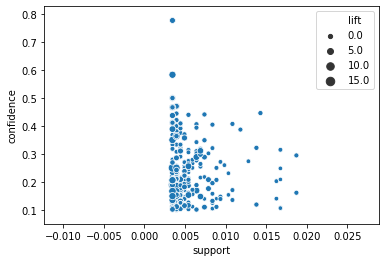

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data = rules, x = 'support', y = 'confidence', size = 'lift' )

It looks like most of the high lift rules are at the lower end of the support range:

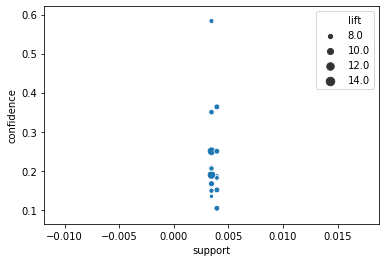

In [23]:
sns.scatterplot(data = rules[rules['lift'] > 8], x = 'support', y = 'confidence', size = 'lift', )

## Evaluate

### Lift

Recall that the lift of a rule A → B measures how much more often A and B occur together than they would if they were statistically independent. So lift is simply the ratio of these values:

Lift(A → B) = Support(A & B) / (Support(A) * Support(B))

Lift can be any positive number: 

- Lift > 1: positive association
- Lift = 1: independent
- Lift < 1: negative association

This time, let's filter by lift to take a look at some of the rules with the highest lift i.e. rules where the presence of the LHS really lifts the likelihood that the RHS will be present too.

In [24]:
frequent_itemsets = apriori(dataset, min_support = 0.003, use_colnames = True)
rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.1)

rules.sort_values(by = 'lift', ascending = False).head(25)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
267,(Organic Garnet Sweet Potato (Yam)),(Organic Red Onion),0.013786,0.018218,0.003447,0.250000,13.722973,0.003195,1.309043
266,(Organic Red Onion),(Organic Garnet Sweet Potato (Yam)),0.018218,0.013786,0.003447,0.189189,13.722973,0.003195,1.216330
318,(Boneless Skinless Chicken Breasts),"(Banana, Organic Baby Spinach)",0.020679,0.016741,0.003447,0.166667,9.955882,0.003100,1.179911
316,"(Banana, Organic Baby Spinach)",(Boneless Skinless Chicken Breasts),0.016741,0.020679,0.003447,0.205882,9.955882,0.003100,1.233218
165,(Jalapeno Peppers),(Limes),0.010832,0.037912,0.003939,0.363636,9.591499,0.003528,1.511852
164,(Limes),(Jalapeno Peppers),0.037912,0.010832,0.003939,0.103896,9.591499,0.003528,1.103854
292,(Original Hummus),(Organic Peeled Whole Baby Carrots),0.026096,0.015756,0.003939,0.150943,9.580189,0.003528,1.159221
291,(Organic Peeled Whole Baby Carrots),(Original Hummus),0.015756,0.026096,0.003939,0.250000,9.580189,0.003528,1.298539
141,(Bunched Cilantro),(Limes),0.009847,0.037912,0.003447,0.350000,9.231818,0.003073,1.480135
329,(Organic Blackberries),"(Banana, Organic Strawberries)",0.023141,0.016741,0.003447,0.148936,8.896746,0.003059,1.155330


You may notice some patterns emerging amongst these high lift rules. Interestingly, Limes seems to be cropping up a few times. Let's focus in on rules that contain just {Limes} on one side!

### Fixing the LHS or RHS

Another thing you may want to do in general is look at rules that have a *particular* itemset in either the antecedent or consequent. For example, you may be interested in rules where the RHS is simply the single itemset {Limes}. 

Let's try the following:

In [25]:
rules[rules.loc[:, "consequents"] == 'Limes']

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Hmmm, it's empty... Strange! But is 'Limes' really the correct thing to be testing for on the RHS? This is a string - are we sure that the data in the 'consequents' column is a string?

Let's look at what Python data type the itemsets are stored as when the mlxtend function creates the rules by looking at the first (i.e. 0th) entry of the 'consequents' column.

In [26]:
rules.loc[0, 'consequents']

frozenset({'Bag of Organic Bananas'})

So the itemsets are in fact stored as **frozensets**! What are these?!

In Python, [**sets**](https://docs.python.org/2/library/sets.html) are like lists, except they are defined with curly brackets {A, B, C} rather than square brackets [A, B, C]. The main defining feature of a set is that order doesn't matter, and it doesn't take repitition of elements into account. Thus, the set {A, A, B, C} and {B, C, A, A, B} are in fact the same as the set {A, B, C} - the corresponding statements would not be true for lists. 

This property makes sense in our context, since we don't care about what order the items are in the basket, or how many of each item there is. The fact that the sets are frozen here just means that the entries can't be changed at all - they are immutable! We don't actually need to include the frozen part in the following:

In [27]:
rules[rules.loc[:, "consequents"] == {'Limes'}].head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
141,(Bunched Cilantro),(Limes),0.009847,0.037912,0.003447,0.350000,9.231818,0.003073,1.480135
165,(Jalapeno Peppers),(Limes),0.010832,0.037912,0.003939,0.363636,9.591499,0.003528,1.511852
167,(Large Lemon),(Limes),0.044806,0.037912,0.007878,0.175824,4.637648,0.006179,1.167333
179,(Organic Cilantro),(Limes),0.022157,0.037912,0.006401,0.288889,7.619913,0.005561,1.352936
181,(Organic Cucumber),(Limes),0.021664,0.037912,0.003939,0.181818,4.795750,0.003118,1.175885


Great, now it works!

Now that we have this capability, we can compare the rules that contain Limes on the RHS to all the rules, to see if they have a higher lift or not on average.

In [28]:
# calculate average lift of entire dataset
lift_series = rules.loc[:, "lift"]

# perform averaging with np.mean function
average_lift = np.mean(lift_series)

print(f"The average lift of all of the rules is: {average_lift}")

The average lift of all of the rules is: 3.3882875425974004


Note the use of [fstrings](https://realpython.com/python-f-strings/) above, which are the current best practice for formatting strings.

Now let's do the same thing for rules that just have Limes in the consequent.

In [29]:
# index rules based on Limes being the only item in the conseqent
index_limes = (rules.loc[:, "consequents"] == {'Limes'})
limes_df = rules[index_limes]

limes_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
141,(Bunched Cilantro),(Limes),0.009847,0.037912,0.003447,0.350000,9.231818,0.003073,1.480135
165,(Jalapeno Peppers),(Limes),0.010832,0.037912,0.003939,0.363636,9.591499,0.003528,1.511852
167,(Large Lemon),(Limes),0.044806,0.037912,0.007878,0.175824,4.637648,0.006179,1.167333
179,(Organic Cilantro),(Limes),0.022157,0.037912,0.006401,0.288889,7.619913,0.005561,1.352936
181,(Organic Cucumber),(Limes),0.021664,0.037912,0.003939,0.181818,4.795750,0.003118,1.175885


In [30]:
# calculate average lift of rules with Limes as the consequent

lime_lift_series = limes_df.loc[:, "lift"]
average_lift_limes = np.mean(lime_lift_series)

print(f"The average lift of just rules with Limes as the consequent is: {average_lift_limes}")

The average lift of just rules with Limes as the consequent is: 5.568311842131619


## Conclusion

So we see that indeed rules with Limes as the consequent have a higher lift than the average and therefore these are pretty interesting rules! If someone buys Cilantro or Jalapenos or Cucumber, they are more likely to buy Limes *compared* to if those antecedent items were not present.

The support of these rules is still pretty low though overall (< 1%) since our threshold was quite low, so although the association is strong, these rules didn't appear in many transactions. Perhaps that is OK in this case, and maybe we are uncovering habits of certain customers (perhaps cocktail or Mexican cuisine enthusiasts?) that might still be useful for us to deploy certain promotions or marketing strategies, even if it is not affecting a large portion of the customer base.

Another thing we want to do in general is tweak both the support and confidence threshold values. You want these to be high enough that we don't produce **all** frequent itemsets or rules, but not so high that we don't see any results coming out. A good strategy is to start high, and slowly bring the thresholds down until you find a sweet spot.

Note however that no amount of tweaking will make interesting rules appear out of nowhere - if there are no such associations in the data, changing the threshold values cannot change this!